In [1]:
!ln -s /data /habitat-api/data

ln: failed to create symbolic link '/habitat-api/data/data': File exists


In [2]:
import habitat
import numpy as np
from tqdm.notebook import tqdm, trange
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
# from tensorboardX import SummaryWriter
from Vec_env import create_envs
from Model import VLocNetPretrained, VLocNet
from Utils import AverageMeter, DepthNorm
from Data import getTrainTestData
from Loss import ssim
import wandb
import os
from map_builder import MapBuilder
import skimage.morphology

In [3]:
%cd ../../../habitat-api/
%ls

/habitat-api
CODE_OF_CONDUCT.md  README.md  habitat/            res/
CONTRIBUTING.md     configs/   habitat.egg-info/   setup.cfg
Dockerfile          data@      habitat_baselines/  setup.py
LICENSE             docs/      pyproject.toml      test/
MANIFEST.in         examples/  requirements.txt    wandb/


#### Create vector of envs for parallel online training

In [4]:
H = 360
W = 640
#----- Previous pointnav config
# config = habitat.get_config(config_paths='configs/tasks/pointnav_gibson.yaml')
# config.defrost()
# config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR',  'DEPTH_SENSOR']
# config.SIMULATOR.RGB_SENSOR.HEIGHT = H
# config.SIMULATOR.RGB_SENSOR.WIDTH = W
# config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
# config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
# config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
# config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# # config.DATASET.DATA_PATH = 'data/datasets/pointnav/gibson/v1/val/val.json.gz'
# config.freeze()
# envs = create_envs(1, config)

In [5]:
# config_paths="./data/habitat-challenge/habitat-challenge-data/challenge_pointnav2020.local.rgbd.yaml"
# config = habitat.get_config(config_paths=config_paths)
# config.defrost()
# config.SIMULATOR.RGB_SENSOR.HEIGHT = H
# config.SIMULATOR.RGB_SENSOR.WIDTH = W
# # config.SIMULATOR.AGENT_0.RADIUS = 0
# # config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0
# # config.SIMULATOR.RGB_SENSOR.POSITION = [0, 0, 0]
# # config.SIMULATOR.DEPTH_SENSOR.POSITION = [0, 0, 0]
# config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
# config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
# config.DATASET.DATA_PATH = './data/datasets/pointnav/gibson/v1/{split}/{split}.json.gz'
# config.DATASET.SPLIT = 'val'
# config.DATASET.SCENES_DIR = '/data/scene_datasets/'
# config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
# config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
# config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.freeze()
# envs = create_envs(1, config)

In [6]:
def build_mapper():
        params = {}
        params['frame_width'] = 640
        params['frame_height'] = 360
        params['fov'] =  70
        params['resolution'] = 5
        params['map_size_cm'] = 2400
        params['agent_min_z'] = 25
        params['agent_max_z'] = 150
        params['agent_height'] = 0.88 * 100
        params['agent_view_angle'] = 0
        params['du_scale'] = 1
        params['vision_range'] = 128
        params['visualize'] = 0
        params['obs_threshold'] = 1
        obstacle_boundary = 5
        mapper = MapBuilder(params)
        return mapper

mapper = build_mapper()

In [7]:
# envs.reset()

In [8]:
!ls 

CODE_OF_CONDUCT.md  MANIFEST.in  docs		   habitat_baselines  setup.cfg
CONTRIBUTING.md     README.md	 examples	   pyproject.toml     setup.py
Dockerfile	    configs	 habitat	   requirements.txt   test
LICENSE		    data	 habitat.egg-info  res		      wandb


In [9]:
path_to_csv = './data/Odom_data/Train/train.csv'
with open(path_to_csv, mode='r') as csv_file:
        for row in csv_file:
            row = row.strip()
#             print(np.array(list(map(np.float, row.split(',')[5].strip('[]')))) + 1)
            print(np.float(row.split(',')[5].strip('[]')))
            break

0.14147973


#### Create net

In [10]:
net = VLocNetPretrained()

In [11]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

cuda:2


#### Import datasets

In [12]:
batch_size = 16
train_data, test_data = getTrainTestData(batch_size, 'data/Odom_data/Without_noise/')

Loading dataset Loaded (3737)
Loading dataset Loaded (371)


16
(16, 128, 128)


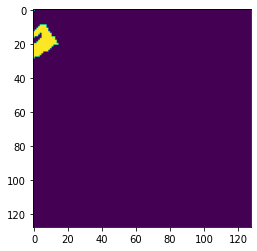

In [13]:
for batch in train_data:
#     print(batch['depth0'].permute(0,2,3,1).shape)
#     print(batch['depth0'].shape)
    print(len(mapper.get_top_down_map(batch['depth0'].squeeze(1).numpy() * 1000)))
    print(mapper.get_top_down_map(batch['depth0'].squeeze(1).numpy() * 1000).shape)
    plt.imshow((mapper.get_top_down_map(batch['depth0'].squeeze(1).numpy() * 1000)[0]))
    break

In [14]:
a = np.array([])
print(a.shape == (0,))
a = np.append(a, [[2,3,4]])
a = np.append(a, [[2,3,4]])
print(a)

True
[2. 3. 4. 2. 3. 4.]


In [15]:
# Logging
wandb.init(project="vloc_net", entity='stepan-makarenko')
# wandb.watch(net)

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/stepan-makarenko/vloc_net/runs/3ibhq71e

In [16]:
for i in train_data:
    print(i['rgb0'].shape)
    break

torch.Size([16, 3, 360, 640])


#### Train on collected dataset

In [17]:
# import copy

def train(net, train_loader, test_loader):
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    N = len(train_loader)
    
    net.to(device)
    losses_train = AverageMeter()
    losses_test = AverageMeter()
    
    best_test_loss = float(np.inf)
#     best_model = copy.deepcopy(net)
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, verbose=True, factor=0.2)
    l1_criterion = nn.L1Loss()
    
    
    for epoch in trange(50):
        net.train()
        for i, sample_batched in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
#             Prepare sample and target
#             rgb0 = sample_batched['rgb0'].to(device)
#             rgb1 = sample_batched['rgb1'].to(device)
#             depth0 = sample_batched['depth0'].to(device)
#             depth1 = sample_batched['depth1'].to(device)
        
            # Predict on top down maps:
            top_down0 = mapper.get_top_down_map(sample_batched['depth0'].squeeze(1).numpy())
            top_down0 = torch.FloatTensor(top_down0).unsqueeze(1).to(device)
            top_down1 = mapper.get_top_down_map(sample_batched['depth1'].squeeze(1).numpy())
            top_down1 = torch.FloatTensor(top_down1).unsqueeze(1).to(device)
            
            in0 = torch.cat((top_down0, top_down0, top_down0), dim=1)
            in1 = torch.cat((top_down1, top_down1, top_down1), dim=1)
            
            
                
            # Predict on depths
#             depth0 = nn.functional.interpolate(depth0, (144, 256))
#             depth1 = nn.functional.interpolate(depth0, (144, 256))
            
#             depth0 = torch.cat((depth0, depth0, depth0), dim=1)
#             depth1 = torch.cat((depth1, depth1, depth1), dim=1)
                       
            compas = sample_batched['compas'].to(device)
#             pred_T, pred_R = net.forward((rgb0, rgb1))
            loc_dT, pred_R = net.forward((in0, in1))
            to_glob = torch.tensor([[[torch.cos(fi), 0, -torch.sin(fi)],
                                       [0, 1, 0], 
                                       [torch.sin(fi), 0, torch.cos(fi)]] for fi in compas])
            to_glob = to_glob.to(device)
#             print()
            pred_T = torch.matmul(to_glob, loc_dT.unsqueeze(2)).squeeze(2)
#             print(loc_dT.shape, to_glob.shape, pred_T.shape)
            
#             print(pred_T, sample_batched['d_gps'].to(device))
#             print(pred_R, sample_batched['d_compas'].to(device))
            loss_T = l1_criterion(pred_T, sample_batched['d_gps'].to(device))
            loss_R = l1_criterion(pred_R, sample_batched['d_compas'].to(device))
#             print(loss_T, loss_R)
#             loss = loss_T + loss_R
            loss = loss_T + loss_R
#             losses_train.update(loss.data.item(), rgb0.size(0))
            losses_train.update(loss.data.item(), in0.size(0))
            
            loss.backward()
            optimizer.step()
            
        # Log progress
#             niter = epoch*N+i
#         if i % 5 == 0:
            # Print to console
#                 print('Epoch: [{0}][{1}/{2}] : train_loss = {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, loss=losses_train))

        # Log to WB
        wandb.log({'Epoch': epoch, 'Train loss': losses_train.avg})
        losses_train.reset()
        
        net.eval()
        with torch.no_grad():
            for j, sample_batched in tqdm(enumerate(test_loader)):

                # Prepare sample and target
#                 rgb0 = sample_batched['rgb0'].to(device)
#                 rgb1 = sample_batched['rgb1'].to(device)
#                 depth0 = sample_batched['depth0'].to(device)
#                 depth1 = sample_batched['depth1'].to(device)
                
                # Predict on top down maps:
                top_down0 = mapper.get_top_down_map(sample_batched['depth0'].squeeze(1).numpy())
                top_down0 = torch.FloatTensor(top_down0).unsqueeze(1).to(device)
                top_down1 = mapper.get_top_down_map(sample_batched['depth1'].squeeze(1).numpy())
                top_down1 = torch.FloatTensor(top_down1).unsqueeze(1).to(device)

                in0 = torch.cat((top_down0, top_down0, top_down0), dim=1)
                in1 = torch.cat((top_down1, top_down1, top_down1), dim=1)
                
                # Predict on depths
#                 depth0 = nn.functional.interpolate(depth0, (144, 256))
#                 depth1 = nn.functional.interpolate(depth0, (144, 256))

#                 depth0 = torch.cat((depth0, depth0, depth0), dim=1)
#                 depth1 = torch.cat((depth1, depth1, depth1), dim=1)
                       
            
                compas = sample_batched['compas'].to(device)
#             pred_T, pred_R = net.forward((rgb0, rgb1))
                loc_dT, pred_R = net.forward((in0, in1))
                to_glob = torch.tensor([[[torch.cos(fi), 0, -torch.sin(fi)],
                                       [0, 1, 0], 
                                       [torch.sin(fi), 0, torch.cos(fi)]] for fi in compas])
                to_glob = to_glob.to(device)
                pred_T = torch.matmul(to_glob, loc_dT.unsqueeze(2)).squeeze(2) 

                loss_T = l1_criterion(pred_T, sample_batched['d_gps'].to(device))
                loss_R = l1_criterion(pred_R, sample_batched['d_compas'].to(device))
                loss_T_abs = loss_T / sample_batched['d_gps'].to(device).abs().mean()
                loss_R_abs = loss_R / sample_batched['d_compas'].to(device).abs().mean()
#                 loss = loss_T + loss_R
                loss = loss_T
#                 losses_test.update(loss.data.item(), rgb0.size(0))
                losses_test.update(loss.data.item(), in0.size(0))

#             if losses_test.avg < best_test_loss:
# #                         torch.save(net.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))
# #                         torch.save(net.state_dict(), "model.pt")
#                 wandb.save('model.pt')
# #                         torch.save(net.state_dict(), 'best_net.pt')
# #                         best_model = copy.deepcopy(net)
#                 best_test_loss = losses_test.avg
            # Print to console
#                 print('Epoch: [{0}][{1}/{2}] : test_loss = {loss.avg:.4f}'.format(epoch, i, N, loss=losses_test))

        # Log to WB
        wandb.log({'Epoch': epoch, 'Test loss': losses_test.avg,
                   'Reletive gps loss': loss_T_abs, 'Reletive compas loss': loss_R_abs})
#                 print(loss_T_abs, loss_R_abs)
        
        scheduler.step(losses_test.avg)
        losses_test.reset()
            

    return net

net = train(net, train_data, test_data)

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch    28: reducing learning rate of group 0 to 2.0000e-05.



Epoch    46: reducing learning rate of group 0 to 4.0000e-06.


In [18]:
for j, sample_batched in enumerate(train_data):
    compas = sample_batched['compas']
    print()
    break

In [23]:
n = 2
net.eval()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
for i, sample_batched in enumerate(train_data):
    top_down0 = mapper.get_top_down_map(sample_batched['depth0'].squeeze(1).numpy())
    top_down0 = torch.FloatTensor(top_down0).unsqueeze(1).to(device)
    top_down1 = mapper.get_top_down_map(sample_batched['depth1'].squeeze(1).numpy())
    top_down1 = torch.FloatTensor(top_down1).unsqueeze(1).to(device)

    in0 = torch.cat((top_down0, top_down0, top_down0), dim=1)
    in1 = torch.cat((top_down1, top_down1, top_down1), dim=1)
    loc_dT, pred_R = net.forward((in0, in1))
    to_glob = torch.tensor([[[torch.cos(fi), 0, -torch.sin(fi)],
                           [0, 1, 0], 
                           [torch.sin(fi), 0, torch.cos(fi)]] for fi in compas])
    to_glob = to_glob.to(device)
    pred_T = torch.matmul(to_glob, loc_dT.unsqueeze(2)).squeeze(2)
    print('Compas', pred_R, sample_batched['d_compas'])
    print('Gps', pred_T, sample_batched['d_gps'])
    if i >= n: 
        break

Compas tensor([[0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125],
        [0.0125]], device='cuda:1', grad_fn=<AddmmBackward>) tensor([[-0.2792],
        [ 0.1283],
        [ 0.1442],
        [ 0.2735],
        [ 0.0022],
        [ 0.2325],
        [ 0.1327],
        [-0.1656],
        [-0.1858],
        [ 0.3054],
        [ 0.0436],
        [ 0.2072],
        [ 0.0904],
        [-0.1990],
        [-0.2497],
        [-0.2488]])
Gps tensor([[ 0.0012, -0.0003, -0.0029],
        [ 0.0013, -0.0003, -0.0028],
        [ 0.0016, -0.0003, -0.0027],
        [ 0.0009, -0.0003, -0.0030],
        [ 0.0012, -0.0003, -0.0029],
        [ 0.0026, -0.0003, -0.0017],
        [ 0.0010, -0.0003, -0.0030],
        [ 0.0012, -0.0003, -0.0029],
        [ 0.0003, -0.0003, -0.0031],
        [ 0.0007, -0

In [ ]:
a = torch.rand((10, 2), requires_grad=True)
c = torch.rand(1, requires_grad=True)

In [ ]:
nn.ELU(inplace=True)(torch.FloatTensor([0.1, -0.1, -10]))

#### Create pretrained ppo agent to perform actions in environment


In [ ]:
from habitat_baselines.agents.ppo_agents import PPOAgent, get_default_config
agent_config = get_default_config()
agent_config.INPUT_TYPE = "rgbd"
agent_config.MODEL_PATH = "./data/agents/rgbd.pth"
agent = PPOAgent(agent_config)
agent.reset()

#### Define training loop and helpfull augmentations

In [ ]:
def train(net, X_train, y_train, losses_train, epoch):
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, betas=(0.9, 0.999))
    l1_criterion = nn.L1Loss()
    
    ###Train loop
    for i in range(epoch):
        optimizer.zero_grad()
        net.train()

        image = torch.autograd.Variable(X_train.to(device))
        depth = torch.autograd.Variable(y_train.to(device, non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm(depth)

        output = net.forward(image)
        output = nn.functional.interpolate(output, (256, 256))

        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
        loss = (1.0 * l_ssim) + (0.1 * l_depth)
        losses_train.update(loss.data.item(), image.size(0))

        loss.backward()
        optimizer.step()
    
    ###
    return net, losses_train

class RandomHorizontalFlip:
    def __call__(self, sample):
        image, depth = sample['rgb'], sample['depth']
        
        if random.random() < 0.5:
            image = np.flip(image, 1)
            depth = np.flip(depth, 1)
        
        return {'rgb': image, 'depth': depth}

class RandomChannelSwap:
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))
    
    def __call__(self, sample):
        image, depth = sample['rgb'], sample['depth']

        if random.random() < self.probability:
            image = image[...,list(self.indices[random.randint(0, len(self.indices) -1)])]
        
        return {'rgb': image, 'depth': depth}

In [ ]:
observations = envs.reset()

X_train = []
y_train = []
epoch = 2


l1_criterion = nn.L1Loss()
losses_train = AverageMeter()
losses_test = AverageMeter()
best_test_loss = float(np.inf)

for i in tqdm(range(1000000)):
    
    
    actions = []
    for observ in observations: 
        action = agent.act(observ)
        actions.append(action['action'])
        
        observ = RandomChannelSwap(0.5)(RandomHorizontalFlip()(observ))
        observ['depth'] = np.clip(observ['depth'] * 1000, 10, 1000)
        
        X_train.append(np.swapaxes(observ['rgb'],0,1)/255)
        y_train.append(np.swapaxes(observ['depth'],0,1))

    if (i + 1) % 8 == 0:
        X_train = torch.FloatTensor(X_train).permute(0, 3, 2, 1)
        y_train = torch.FloatTensor(y_train).permute(0, 3, 2, 1)
        
        
        net, losses_train = train(net, X_train, y_train, losses_train, epoch)

        ###
        if i % 2 == 1:
            print('epoch {} : train_loss = {}'.format(i, losses_train.avg))
            wandb.log({'Iteration': i, 'Online train loss': losses_train.val})
        
        losses_train.reset()
        X_train = []
        y_train = []
        
    if (i) % 300 == 0:
        with torch.no_grad():
            net.eval()

            for sample_batched in tqdm(test_data):
            
                image = torch.autograd.Variable(sample_batched['image'].to(device))
                depth = torch.autograd.Variable(sample_batched['depth'].to(device, non_blocking=True))

                # Normalize depth

                output = DepthNorm(net.forward(image))
                output = nn.functional.interpolate(output, (256, 256))
                
                l_depth = l1_criterion(output, depth)
                l_ssim = torch.clamp((1 - ssim(output, depth, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
                loss = (1.0 * l_ssim) + (0.1 * l_depth)
                losses_test.update(loss.data.item(), image.size(0))
                
            ### Image save

            scen_num = np.random.randint(batch_size)
            for d in test_data:
                x = d['image'][scen_num]
                y = d['depth'][scen_num] / 1000
                x = x.permute(1,2,0)
                y = y.permute(1,2,0)
                break

            d = d['image'].to(device)
            my_depth = net.forward(d)
            my_depth = nn.functional.interpolate(my_depth, (256, 256))
            my_depth = my_depth.permute(0, 2, 3, 1)
            my_depth_numpy = my_depth.cpu().detach().numpy()[scen_num]

            fig = plt.figure(figsize=(15,15))
            a = fig.add_subplot(1, 3, 1)
            imgplot = plt.imshow(x)
            a.set_title('Img')
            a = fig.add_subplot(1, 3, 2)
            imgplot = plt.imshow(np.concatenate((y, y, y), axis=2))
            a.set_title('True_depth')
            a = fig.add_subplot(1, 3, 3)
            imgplot = plt.imshow(np.concatenate((1/my_depth_numpy, 1/my_depth_numpy, 1/my_depth_numpy), axis=2))
            a.set_title('Predict_depth')
            
            wandb.log({'Iteration': i, 'Online example depth': wandb.Image(fig)})

            ###
        print('epoch {} : test_loss = {}'.format(i, losses_test.avg))
        wandb.log({'Iteration': i, 'Online test loss': losses_test.avg})

        if losses_test.avg < best_test_loss:
            torch.save(net.state_dict(), "online_model.pt")
            wandb.save('online_model.pt')
            best_test_loss = losses_test.avg
        losses_test.reset()
    
    actions = np.array(actions)
    actions = (actions + 1) % 4
    observations = envs.step(actions)